In [2]:
# Methodology for Analysing Discourses of Energy Saving Delay

In [3]:
# import important packages
import pandas as pd
import sqlite3
import os
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import numpy as np
from sklearn.preprocessing import OneHotEncoder
import ast
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from collections import Counter
import nltk
from nltk.corpus import stopwords
import string
import networkx as nx
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from nltk.tokenize import word_tokenize
from adjustText import adjust_text

nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('wordnet')



[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\e.baumhoever\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\e.baumhoever\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\e.baumhoever\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\e.baumhoever\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\e.baumhoever\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
# load the dataset
energy_df = pd.read_csv('Data/new_categories_corpus_tweets_energy_saving_random_sample_1000.csv', sep=';',encoding='utf-8-sig', keep_default_na=False)

print(energy_df.head())


       id                                                url  \
0  325707  https://twitter.com/symptompanik/status/152112...   
1  339208  https://twitter.com/Labor2b/status/15410523219...   
2  407229  https://twitter.com/DE_Spindoctors/status/1579...   
3  318537  https://twitter.com/mikele_gross/status/150952...   
4  318130  https://twitter.com/Claudia13772006/status/150...   

                    datetime                  name         username  \
0  2022-05-02 13:37:01+00:00              🇩🇪Sava🛡️     symptompanik   
1  2022-06-26 13:34:39+00:00               Labor2b          Labor2b   
2  2022-10-09 10:50:42+00:00  political-consultant   DE_Spindoctors   
3  2022-03-31 13:29:20+00:00          mikele gross     mikele_gross   
4  2022-03-30 22:04:07+00:00            Claudia J.  Claudia13772006   

                                             content  possibly_sensitive  \
0  Ich schlage vor die Bundesregierung ins Homeof...               False   
1  @MoebusAnne Darum ja Gas sparen. 

In [5]:
# change relevant coloumns to integer format
columns_to_int = ['random','discourse_category','discourse_category_2']
energy_df[columns_to_int] = energy_df[columns_to_int].apply(pd.to_numeric, errors='coerce').astype('Int64')

In [6]:
print(energy_df.dtypes)

id                                  int64
url                                object
datetime                           object
name                               object
username                           object
content                            object
possibly_sensitive                   bool
reply_settings                     object
public_metrics.retweet_count        int64
public_metrics.reply_count          int64
public_metrics.like_count           int64
public_metrics.quote_count          int64
public_metrics.impression_count     int64
description                        object
public_metrics.followers_count      int64
public_metrics.following_count      int64
public_metrics.tweet_count          int64
public_metrics.listed_count         int64
verified                             bool
content_short                      object
category                           object
frame                               int64
FRAME                              object
stance                            

In [7]:
# Descriptive statistics

In [8]:
# Frequency Counts for Discourse Categories

print("Frequency counts for discourse_category:")
category_counts = energy_df['discourse_category'].value_counts()
print(category_counts)

# Frequnency Table
freq_table = category_counts.reset_index()
freq_table.columns = ['Discourse Category', 'Count']
print("\nFrequency Table:")
print(freq_table)

Frequency counts for discourse_category:
discourse_category
6     218
3     156
1     144
10     86
7      85
5      80
8      70
9      60
2      48
4      18
Name: count, dtype: Int64

Frequency Table:
   Discourse Category  Count
0                   6    218
1                   3    156
2                   1    144
3                  10     86
4                   7     85
5                   5     80
6                   8     70
7                   9     60
8                   2     48
9                   4     18


In [9]:
# Overview of Likes, Retweets, Replies (average and total)

# Total_engagement column 
if 'total_engagement' not in energy_df.columns:
    energy_df['total_engagement'] = energy_df['public_metrics.like_count'] + energy_df['public_metrics.retweet_count'] + energy_df['public_metrics.reply_count']

# Filter out not categorised tweets
filtered_stats = energy_df[energy_df['discourse_category'] != '<NA>']

grouped_stats = filtered_stats.groupby("discourse_category").agg(
    Avg_Likes=("public_metrics.like_count", "mean"),
    Avg_Retweets=("public_metrics.retweet_count", "mean"),
    Avg_Replies=("public_metrics.reply_count", "mean"),
    Total_Likes=("public_metrics.like_count", "sum"),
    Total_Retweets=("public_metrics.retweet_count", "sum"),
    Total_Replies=("public_metrics.reply_count", "sum"),
    Tweets_Count=("discourse_category", "count"),
    Total_Engagement=("total_engagement", "sum"),
    Avg_Total_Engagement=("total_engagement", "mean")
).reset_index()

grouped_stats[['Avg_Likes', 'Avg_Retweets', 'Avg_Replies']] = grouped_stats[['Avg_Likes', 'Avg_Retweets', 'Avg_Replies']].round(2)

print(grouped_stats)


   discourse_category  Avg_Likes  Avg_Retweets  Avg_Replies  Total_Likes  \
0                   1      20.88          2.90         1.12         3006   
1                   2       4.54          1.50         0.50          218   
2                   3       6.20          0.94         0.76          967   
3                   4      11.72          1.67         1.11          211   
4                   5       1.12          0.12         0.42           90   
5                   6      28.69          4.41         1.27         6254   
6                   7       1.91          0.12         0.36          162   
7                   8       4.59          0.64         0.69          321   
8                   9       6.17          1.33         0.45          370   
9                  10       6.27          1.35         0.77          539   

   Total_Retweets  Total_Replies  Tweets_Count  Total_Engagement  \
0             418            162           144              3586   
1              72          

In [10]:
# Mean, Median, Std, Variance, Skewness for Likes, Retweets, Replies and Total Engagement
stats_by_category = energy_df.groupby("discourse_category").agg({
    "public_metrics.like_count": ["mean", "median", "std", "var", "skew"],
    "public_metrics.retweet_count": ["mean", "median", "std", "var", "skew"],
    "public_metrics.reply_count": ["mean", "median", "std", "var", "skew"],
    "total_engagement": ["mean", "median", "std", "var", "skew"]
}).reset_index()

stats_by_category.columns = ["_".join(col).strip("_") for col in stats_by_category.columns.values]

print(stats_by_category)
display(stats_by_category)



   discourse_category  public_metrics.like_count_mean  \
0                   1                       20.875000   
1                   2                        4.541667   
2                   3                        6.198718   
3                   4                       11.722222   
4                   5                        1.125000   
5                   6                       28.688073   
6                   7                        1.905882   
7                   8                        4.585714   
8                   9                        6.166667   
9                  10                        6.267442   

   public_metrics.like_count_median  public_metrics.like_count_std  \
0                               1.0                     186.021199   
1                               0.0                      20.063684   
2                               1.0                      25.734480   
3                               2.0                      23.018677   
4                     

,discourse_category,public_metrics.like_count_mean,public_metrics.like_count_median,public_metrics.like_count_std,public_metrics.like_count_var,public_metrics.like_count_skew,public_metrics.retweet_count_mean,public_metrics.retweet_count_median,public_metrics.retweet_count_std,public_metrics.retweet_count_var,...,public_metrics.reply_count_mean,public_metrics.reply_count_median,public_metrics.reply_count_std,public_metrics.reply_count_var,public_metrics.reply_count_skew,total_engagement_mean,total_engagement_median,total_engagement_std,total_engagement_var,total_engagement_skew
0,1,20.875000,1.0,186.021199,34603.886364,11.673238,2.902778,0.0,28.339184,803.109363,...,1.125000,0.0,5.809174,33.746503,10.085421,24.902778,1.0,219.961164,48382.913559,11.655291
1,2,4.541667,0.0,20.063684,402.551418,6.678785,1.500000,0.0,8.805221,77.531915,...,0.500000,0.0,1.271622,1.617021,4.729182,6.541667,1.0,29.941047,896.466312,6.758957
2,3,6.198718,1.0,25.734480,662.263482,6.907628,0.942308,0.0,4.963402,24.635360,...,0.756410,0.0,2.144375,4.598346,6.274613,7.897436,1.0,31.980070,1022.724897,6.730805
3,4,11.722222,2.0,23.018677,529.859477,2.654130,1.666667,0.0,3.613699,13.058824,...,1.111111,0.0,2.111283,4.457516,2.198945,14.500000,2.5,27.880522,777.323529,2.732825
4,5,1.125000,0.0,1.694182,2.870253,1.993883,0.125000,0.0,0.919204,0.844937,...,0.425000,0.0,1.052724,1.108228,5.143813,1.675000,1.0,2.689760,7.234810,3.046241
5,6,28.688073,1.0,251.232343,63117.690272,13.446988,4.408257,0.0,35.077706,1230.445461,...,1.270642,0.0,8.291085,68.742083,11.731448,34.366972,1.0,292.873250,85774.740287,13.155900
6,7,1.905882,0.0,3.500420,12.252941,3.562988,0.117647,0.0,0.565091,0.319328,...,0.364706,0.0,0.574188,0.329692,1.325139,2.388235,1.0,4.197772,17.621289,3.735446
7,8,4.585714,1.0,11.669970,136.188199,3.580564,0.642857,0.0,2.455610,6.030021,...,0.685714,0.0,1.967437,3.870807,4.721219,5.914286,1.0,15.334666,235.151967,3.629126
8,9,6.166667,0.5,16.845426,283.768362,5.161982,1.333333,0.0,3.895528,15.175141,...,0.450000,0.0,0.928367,0.861864,2.911983,7.950000,1.0,21.145521,447.133051,4.876610
9,10,6.267442,1.0,21.432479,459.351163,5.432426,1.348837,0.0,6.487576,42.088646,...,0.767442,0.0,1.920015,3.686457,4.168683,8.383721,1.0,29.474283,868.733379,5.657715


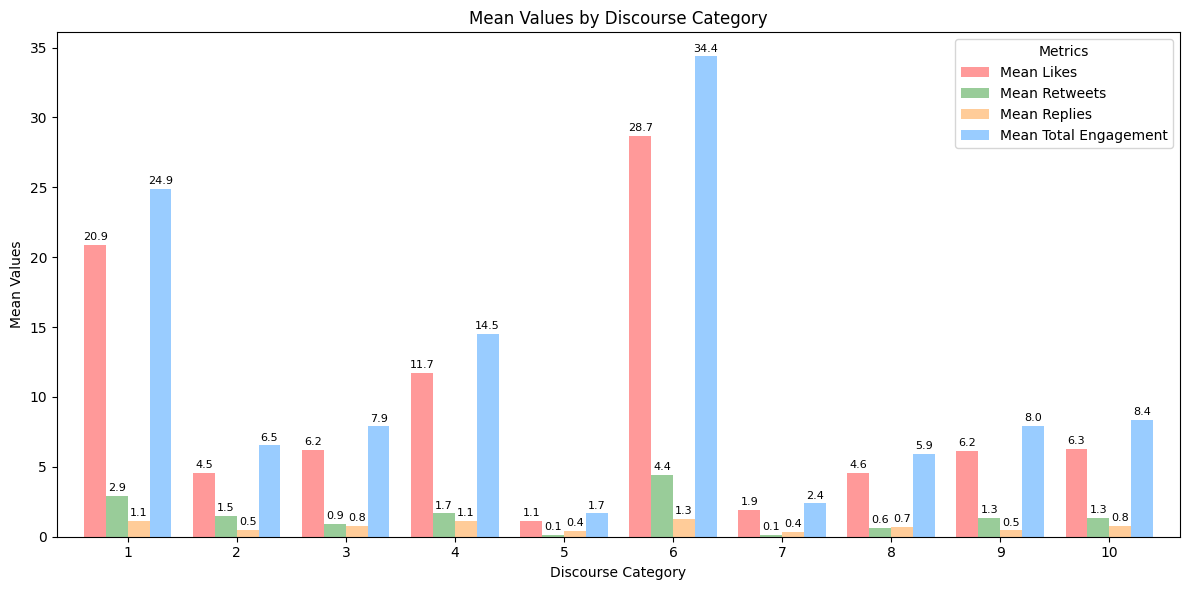

In [11]:
# Visualisation of mean values (bar plot)
mean_values = stats_by_category.filter(like="_mean").dropna()
mean_values.set_index(stats_by_category["discourse_category"], inplace=True)

mean_values = mean_values.loc[[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]]
mean_values.index = mean_values.index.astype(str)

ax = mean_values.plot(kind="bar", figsize=(12, 6), color=['#FF9999', '#99CC99', '#FFCC99', '#99CCFF'], width=0.8) 
plt.title("Mean Values by Discourse Category")
plt.xlabel("Discourse Category")
plt.ylabel("Mean Values")
plt.xticks(rotation=0)
plt.legend(["Mean Likes", "Mean Retweets", "Mean Replies", "Mean Total Engagement"], loc="upper right", title="Metrics")

for p in ax.patches:
    height = p.get_height()
    if height > 0:  
        ax.annotate(f'{height:.1f}', 
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='bottom', 
                    xytext=(0, 2), textcoords='offset points', 
                    fontsize=8)  

plt.tight_layout()
plt.show()


C:\Users\e.baumhoever\AppData\Local\Temp\ipykernel_16600\3300502171.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='discourse_category',
C:\Users\e.baumhoever\AppData\Local\Temp\ipykernel_16600\3300502171.py:3: UserWarning: 
The palette list has fewer values (1) than needed (10) and will cycle, which may produce an uninterpretable plot.
  ax = sns.countplot(x='discourse_category',


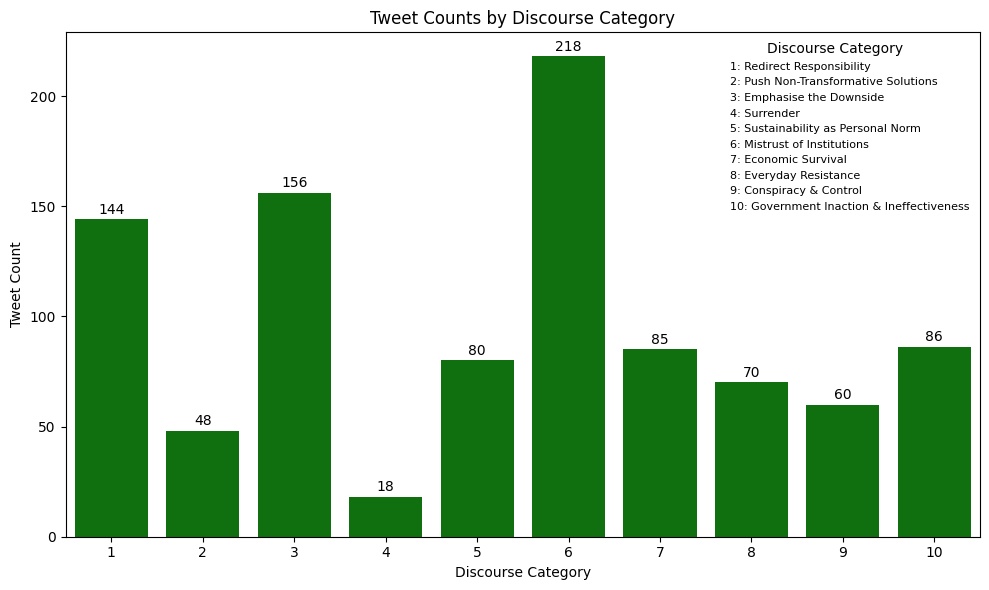

In [12]:
# Visualisation of total values (bar plot)
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='discourse_category', 
                   data=energy_df,  
                   palette=['green'],  
                   order=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])

plt.title('Tweet Counts by Discourse Category')
plt.xlabel('Discourse Category')
plt.ylabel('Tweet Count')
plt.tight_layout()

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{int(height)}', 
                (p.get_x() + p.get_width() / 2., height), 
                ha='center', va='bottom', 
                xytext=(0, 2), textcoords='offset points', 
                fontsize=10, color='black')

category_labels = {
    '1': 'Redirect Responsibility',
    '2': 'Push Non-Transformative Solutions',
    '3': 'Emphasise the Downside',
    '4': 'Surrender',
    '5': 'Sustainability as Personal Norm',
    '6': 'Mistrust of Institutions',
    '7': 'Economic Survival',
    '8': 'Everyday Resistance',
    '9': 'Conspiracy & Control',
    '10': 'Government Inaction & Ineffectiveness'
}

legend_handles = [mpatches.Patch(color='none', label=f"{i+1}: {category_labels[str(i+1)]}") for i in range(10)]
ax.legend(handles=legend_handles, title='Discourse Category', loc='upper right', prop={'size': 8}, frameon=False)

plt.show()


C:\Users\e.baumhoever\AppData\Local\Temp\ipykernel_16600\1186027233.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=mean_likes_by_category.index,
C:\Users\e.baumhoever\AppData\Local\Temp\ipykernel_16600\1186027233.py:6: UserWarning: 
The palette list has fewer values (1) than needed (10) and will cycle, which may produce an uninterpretable plot.
  ax = sns.barplot(x=mean_likes_by_category.index,


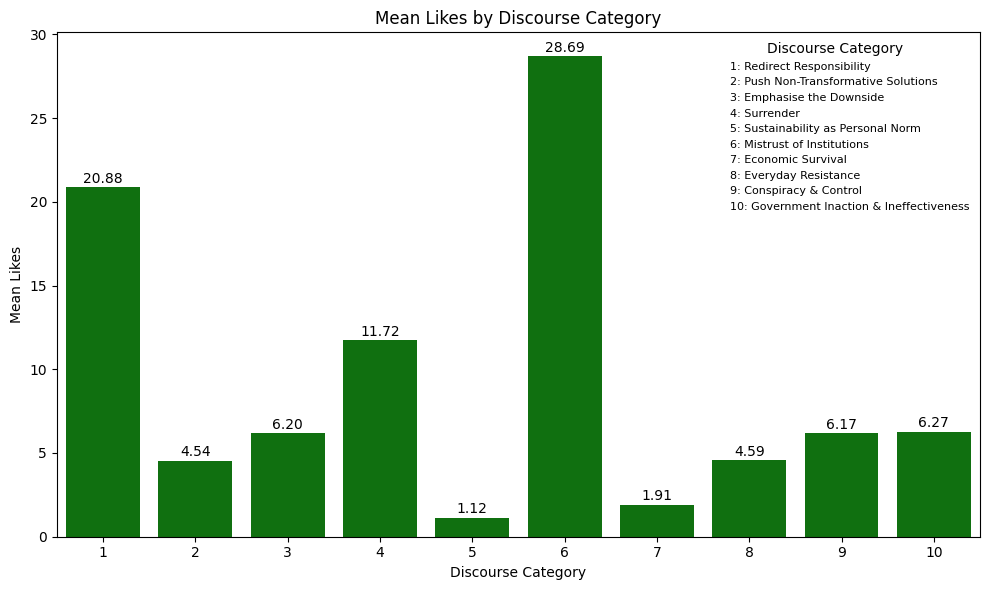

In [13]:
# Visualisation of Mean Likes by Discourse Category (bar plot)

mean_likes_by_category = energy_df[energy_df['discourse_category'] != '<NA>'].groupby('discourse_category')['public_metrics.like_count'].mean().sort_index()

plt.figure(figsize=(10, 6))
ax = sns.barplot(x=mean_likes_by_category.index, 
                 y=mean_likes_by_category.values, 
                 palette=['green'],
                 order=['1', '2', '3', '4','5','6','7','8','9','10'])
plt.title("Mean Likes by Discourse Category")
plt.xlabel("Discourse Category")
plt.ylabel("Mean Likes")
plt.tight_layout()

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.2f}' if height % 1 != 0 else f'{int(height)}', 
                (p.get_x() + p.get_width() / 2., height), 
                ha='center', va='bottom', xytext=(0, 1), textcoords='offset points')

category_labels = {
    '1': 'Redirect Responsibility',
    '2': 'Push Non-Transformative Solutions',
    '3': 'Emphasise the Downside',
    '4': 'Surrender',
    '5': 'Sustainability as Personal Norm',
    '6': 'Mistrust of Institutions',
    '7': 'Economic Survival',
    '8': 'Everyday Resistance',
    '9': 'Conspiracy & Control',
    '10': 'Government Inaction & Ineffectiveness'
}

legend_handles = [mpatches.Patch(color='none', label=f"{i+1}: {category_labels[str(i+1)]}") for i in range(10)]

ax.legend(handles=legend_handles, title='Discourse Category', loc='upper right', prop={'size': 8}, frameon=False)

plt.show()

C:\Users\e.baumhoever\AppData\Local\Temp\ipykernel_16600\468015772.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax=sns.barplot(x=mean_retweets_by_category.index,
C:\Users\e.baumhoever\AppData\Local\Temp\ipykernel_16600\468015772.py:6: UserWarning: 
The palette list has fewer values (1) than needed (10) and will cycle, which may produce an uninterpretable plot.
  ax=sns.barplot(x=mean_retweets_by_category.index,


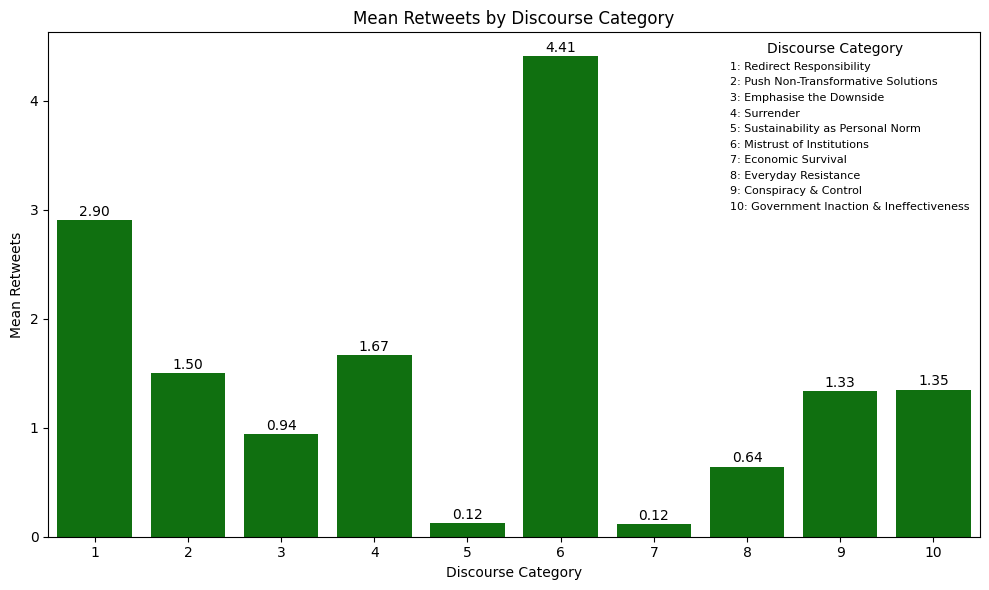

In [14]:
# Visualisation of Mean Retweets by Discourse Category (bar plot)

mean_retweets_by_category = energy_df[energy_df['discourse_category'] != '<NA>'].groupby('discourse_category')['public_metrics.retweet_count'].mean().sort_index()

plt.figure(figsize=(10, 6))
ax=sns.barplot(x=mean_retweets_by_category.index, 
               y=mean_retweets_by_category.values, 
               palette=['green'],
               order=['1', '2', '3', '4','5','6','7','8','9','10'])
plt.title("Mean Retweets by Discourse Category")
plt.xlabel("Discourse Category")
plt.ylabel("Mean Retweets")
plt.tight_layout()

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.2f}' if height % 1 != 0 else f'{int(height)}', 
                (p.get_x() + p.get_width() / 2., height), 
                ha='center', va='bottom', xytext=(0, 1), textcoords='offset points')

category_labels = {
    '1': 'Redirect Responsibility',
    '2': 'Push Non-Transformative Solutions',
    '3': 'Emphasise the Downside',
    '4': 'Surrender',
    '5': 'Sustainability as Personal Norm',
    '6': 'Mistrust of Institutions',
    '7': 'Economic Survival',
    '8': 'Everyday Resistance',
    '9': 'Conspiracy & Control',
    '10': 'Government Inaction & Ineffectiveness'
}

legend_handles = [mpatches.Patch(color='none', label=f"{i+1}: {category_labels[str(i+1)]}") for i in range(10)]

ax.legend(handles=legend_handles, title='Discourse Category', loc='upper right', prop={'size': 8}, frameon=False)

plt.show()

C:\Users\e.baumhoever\AppData\Local\Temp\ipykernel_16600\2231816172.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax=sns.barplot(x=mean_reply_by_category.index,
C:\Users\e.baumhoever\AppData\Local\Temp\ipykernel_16600\2231816172.py:6: UserWarning: 
The palette list has fewer values (1) than needed (10) and will cycle, which may produce an uninterpretable plot.
  ax=sns.barplot(x=mean_reply_by_category.index,


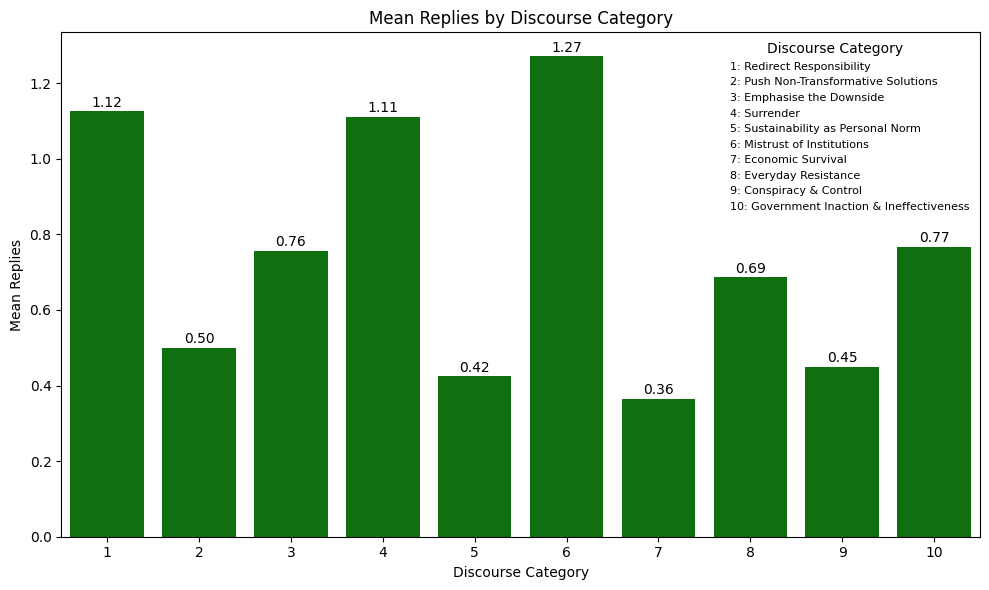

In [15]:
# Visualisation of Mean Replies by Discourse Category (bar plot)

mean_reply_by_category = energy_df[energy_df['discourse_category'] != '<NA>'].groupby('discourse_category')['public_metrics.reply_count'].mean().sort_index()

plt.figure(figsize=(10, 6))
ax=sns.barplot(x=mean_reply_by_category.index, 
               y=mean_reply_by_category.values, 
               palette=['green'],
               order=['1', '2', '3', '4','5','6','7','8','9','10'])
plt.title("Mean Replies by Discourse Category")
plt.xlabel("Discourse Category")
plt.ylabel("Mean Replies")
plt.tight_layout()

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.2f}' if height % 1 != 0 else f'{int(height)}', 
                (p.get_x() + p.get_width() / 2., height), 
                ha='center', va='bottom', xytext=(0, 1), textcoords='offset points')

category_labels = {
    '1': 'Redirect Responsibility',
    '2': 'Push Non-Transformative Solutions',
    '3': 'Emphasise the Downside',
    '4': 'Surrender',
    '5': 'Sustainability as Personal Norm',
    '6': 'Mistrust of Institutions',
    '7': 'Economic Survival',
    '8': 'Everyday Resistance',
    '9': 'Conspiracy & Control',
    '10': 'Government Inaction & Ineffectiveness'
}

legend_handles = [mpatches.Patch(color='none', label=f"{i+1}: {category_labels[str(i+1)]}") for i in range(10)]

ax.legend(handles=legend_handles, title='Discourse Category', loc='upper right', prop={'size': 8}, frameon=False)

plt.show()

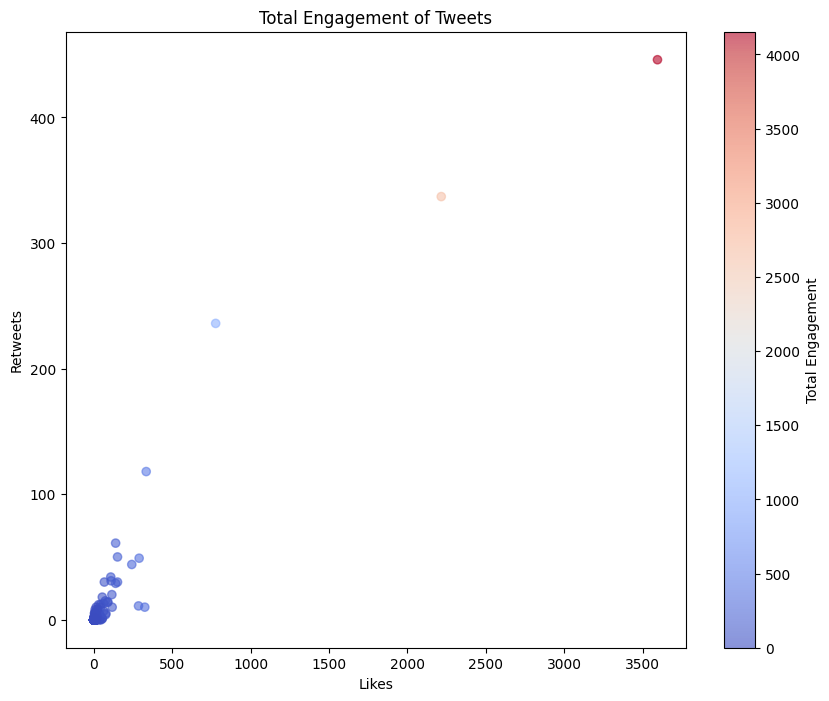

C:\Users\e.baumhoever\AppData\Local\Temp\ipykernel_16600\3704329217.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=energy_df['engagement_category'],


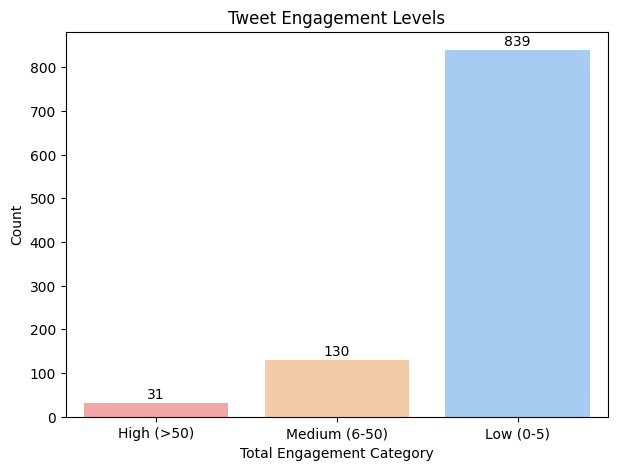

C:\Users\e.baumhoever\AppData\Local\Temp\ipykernel_16600\3704329217.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='engagement_category',


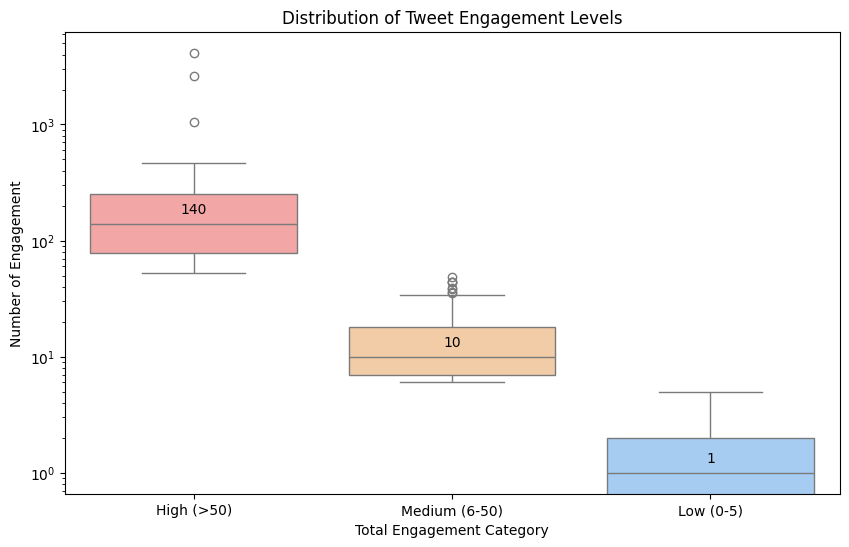

In [16]:
# Distribution of Engagement (high, medium, low) (scatter plot, bar plot and box plot)

if 'total_engagement' not in energy_df.columns:
    energy_df['total_engagement'] = energy_df['public_metrics.like_count'] + energy_df['public_metrics.retweet_count'] + energy_df['public_metrics.reply_count']

# Scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(energy_df['public_metrics.like_count'], 
            energy_df['public_metrics.retweet_count'], 
            c=energy_df['total_engagement'], 
            cmap='coolwarm', alpha=0.6)
plt.xlabel('Likes') 
plt.ylabel('Retweets')
plt.title('Total Engagement of Tweets')
plt.colorbar(label='Total Engagement')
plt.show()

def engagement_category(total_engagement):
    if total_engagement <= 5:
        return "Low (0-5)"
    elif total_engagement <= 50:
        return "Medium (6-50)"
    else:
        return "High (>50)"

energy_df['engagement_category'] = energy_df['total_engagement'].apply(engagement_category)

# Bar plot
plt.figure(figsize=(7, 5))
ax = sns.countplot(x=energy_df['engagement_category'], 
                   palette={'High (>50)': '#FF9999', 'Medium (6-50)': '#FFCC99', 'Low (0-5)': '#99CCFF'}, 
                   order=['High (>50)', 'Medium (6-50)', 'Low (0-5)'])
plt.title("Tweet Engagement Levels")
plt.xlabel("Total Engagement Category")
plt.ylabel("Count")

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{int(height)}', (p.get_x() + p.get_width() / 2., height), 
                ha='center', va='bottom', xytext=(0, 1), textcoords='offset points')

plt.show()

# Box plot
plt.figure(figsize=(10, 6))
ax = sns.boxplot(x='engagement_category', 
                 y='total_engagement', 
                 data=energy_df, 
                 palette={'High (>50)': '#FF9999', 'Medium (6-50)': '#FFCC99', 'Low (0-5)': '#99CCFF'}, 
                 order=['High (>50)', 'Medium (6-50)', 'Low (0-5)'])
plt.title("Distribution of Tweet Engagement Levels")
plt.xlabel("Total Engagement Category")
plt.ylabel("Number of Engagement")
plt.yscale('log') 

medians = energy_df.groupby('engagement_category')['total_engagement'].median()
for i, median in enumerate(medians.loc[['High (>50)', 'Medium (6-50)', 'Low (0-5)']]):
    ax.annotate(f'{int(median)}', (i, median), ha='center', va='bottom', fontsize=10, color='black', xytext=(0, 5), textcoords='offset points')

plt.show()

C:\Users\e.baumhoever\AppData\Local\Temp\ipykernel_16600\605601079.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax=sns.barplot(x=total_engagement_by_category.index,
C:\Users\e.baumhoever\AppData\Local\Temp\ipykernel_16600\605601079.py:5: UserWarning: 
The palette list has fewer values (1) than needed (10) and will cycle, which may produce an uninterpretable plot.
  ax=sns.barplot(x=total_engagement_by_category.index,


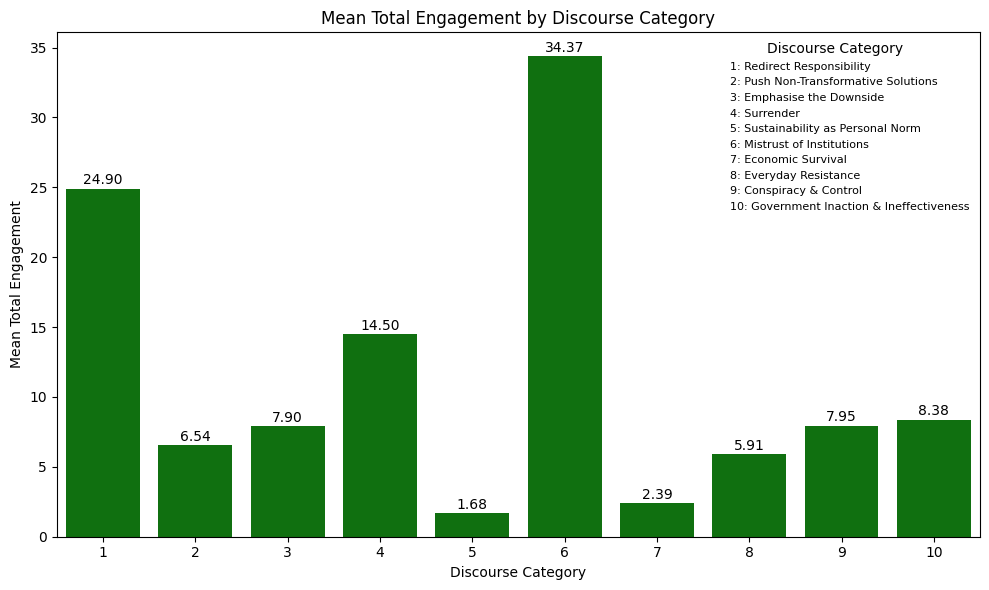

In [17]:
# Total Engagement by Discourse Category (Bar plot)
total_engagement_by_category = energy_df[energy_df['discourse_category'] != '<NA>'].groupby('discourse_category')['total_engagement'].mean().sort_index()

plt.figure(figsize=(10, 6))
ax=sns.barplot(x=total_engagement_by_category.index, 
               y=total_engagement_by_category.values, 
               palette=['green'],
               order=['1', '2', '3', '4','5','6','7','8','9','10'])
plt.title("Mean Total Engagement by Discourse Category")
plt.xlabel("Discourse Category")
plt.ylabel("Mean Total Engagement")
plt.tight_layout()

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.2f}' if height % 1 != 0 else f'{int(height)}', 
                (p.get_x() + p.get_width() / 2., height), 
                ha='center', va='bottom', xytext=(0, 1), textcoords='offset points')

category_labels = {
    '1': 'Redirect Responsibility',
    '2': 'Push Non-Transformative Solutions',
    '3': 'Emphasise the Downside',
    '4': 'Surrender',
    '5': 'Sustainability as Personal Norm',
    '6': 'Mistrust of Institutions',
    '7': 'Economic Survival',
    '8': 'Everyday Resistance',
    '9': 'Conspiracy & Control',
    '10': 'Government Inaction & Ineffectiveness'
}

legend_handles = [mpatches.Patch(color='none', label=f"{i+1}: {category_labels[str(i+1)]}") for i in range(10)]

ax.legend(handles=legend_handles, title='Discourse Category', loc='upper right', prop={'size': 8}, frameon=False)

plt.show()

C:\Users\e.baumhoever\AppData\Local\Temp\ipykernel_16600\1494530730.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='discourse_category',
C:\Users\e.baumhoever\AppData\Local\Temp\ipykernel_16600\1494530730.py:4: UserWarning: 
The palette list has fewer values (1) than needed (10) and will cycle, which may produce an uninterpretable plot.
  ax = sns.boxplot(x='discourse_category',


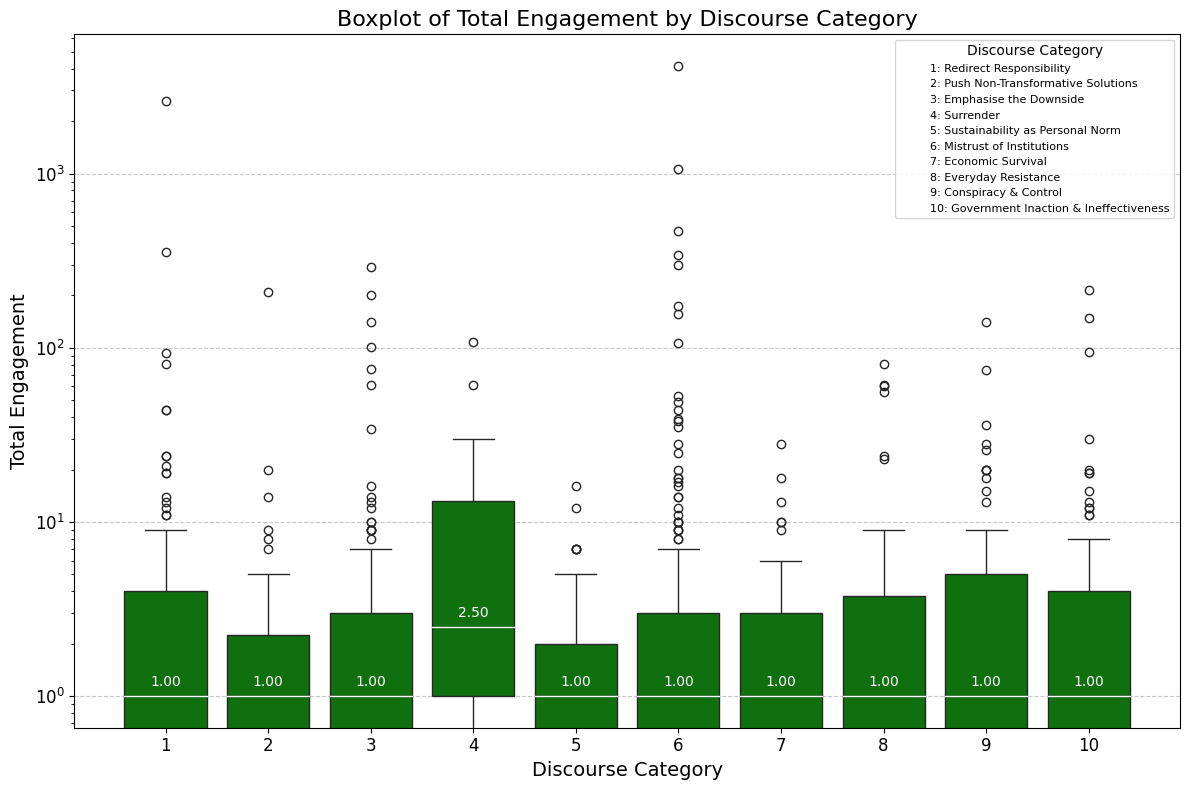

In [18]:
# Total Engagement by Discourse Category (Box plot) normalised by log scale

plt.figure(figsize=(12, 8))
ax = sns.boxplot(x='discourse_category', 
                 y='total_engagement', 
                 data=energy_df, 
                 palette= ['green'], 
                 order=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])

plt.title("Boxplot of Total Engagement by Discourse Category", fontsize=16)
plt.xlabel("Discourse Category", fontsize=14)
plt.ylabel("Total Engagement", fontsize=14)
plt.yscale('log')  
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.grid(axis='y', linestyle='--', alpha=0.7)

medians = energy_df.groupby('discourse_category')['total_engagement'].median()

for i, median in enumerate(medians.loc[[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]]):
    ax.annotate(f'{median:.2f}', (i, median), ha='center', va='bottom', 
                fontsize=10, color='white', xytext=(0, 5), textcoords='offset points')

for i, median in enumerate(medians.loc[[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]]):
    ax.plot([i - 0.4, i + 0.4], [median, median], color='white', linestyle='-', linewidth=1, zorder=3)

legend_handles = [mpatches.Patch(color='none', label=f"{i+1}: {category_labels[str(i+1)]}") 
                  for i in range(10)]

ax.legend(handles=legend_handles, title='Discourse Category', loc='upper right', prop={'size': 8})

plt.tight_layout()

plt.show()


C:\Users\e.baumhoever\AppData\Local\Temp\ipykernel_16600\2937608850.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_stats['sentiment'] = filtered_stats['content'].apply(lambda x: analyzer.polarity_scores(x)['compound'])
C:\Users\e.baumhoever\AppData\Local\Temp\ipykernel_16600\2937608850.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=mean_sentiment_discourse.index,


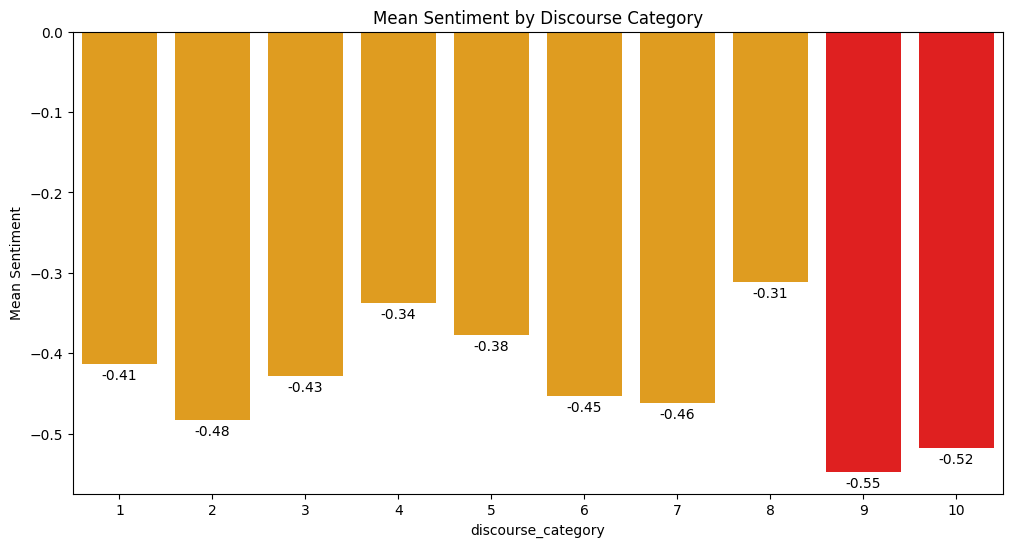

Mean Sentiment by Discourse Category:
Discourse Category 1: -0.41
Discourse Category 2: -0.48
Discourse Category 3: -0.43
Discourse Category 4: -0.34
Discourse Category 5: -0.38
Discourse Category 6: -0.45
Discourse Category 7: -0.46
Discourse Category 8: -0.31
Discourse Category 9: -0.55
Discourse Category 10: -0.52


In [19]:
# Analysis of Sentiment by Discourse Category

filtered_stats['sentiment'] = filtered_stats['content'].apply(lambda x: analyzer.polarity_scores(x)['compound'])
mean_sentiment_discourse = filtered_stats.groupby('discourse_category')['sentiment'].mean()
colors = mean_sentiment_discourse.apply(lambda x: 'red' if x < -0.5 else ('orange' if x < 0 else 'green')).tolist()

plt.figure(figsize=(12, 6))
ax = sns.barplot(x=mean_sentiment_discourse.index,
                 y=mean_sentiment_discourse.values,
                 palette=colors,
                 order=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])

plt.ylabel("Mean Sentiment")
plt.title("Mean Sentiment by Discourse Category")

for p, value in zip(ax.patches, mean_sentiment_discourse.values):
    height = p.get_height()
    ax.annotate(f'{value:.2f}', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='top', xytext=(0, -3), textcoords='offset points')

plt.show()

# Print each mean sentiment value with its corresponding discourse category
print("Mean Sentiment by Discourse Category:")
for category, sentiment in mean_sentiment_discourse.items():
    print(f"Discourse Category {category}: {sentiment:.2f}")


In [20]:
# Frequency Analysis of recurring words in tweets

german_stopwords = stopwords.words('german')
additional_stopwords = ['und', 'die', 'der', 'ich', 'da', 'sie','energie', 'sparen', 'energiesparen', 'spare', 'ja', 'gas', 'mehr', 'sollen', 'geht','spart']
german_stopwords.extend(additional_stopwords)
categories = energy_df['discourse_category'].dropna().unique()
top_words_by_category = {}

print("Top words per discourse category (Frequency Analysis):\n")
for category in categories:
    df_cat = energy_df[energy_df['discourse_category'] == category]
    vectorizer = CountVectorizer(stop_words=german_stopwords, max_features=1000)
    X = vectorizer.fit_transform(df_cat['content_short'])
    feature_names = vectorizer.get_feature_names_out()
    word_counts = np.asarray(X.sum(axis=0)).ravel()
    top_indices = np.argsort(word_counts)[::-1][:10]
    top_words = [(feature_names[i], word_counts[i]) for i in top_indices]
    top_words_by_category[category] = top_words
    
    print(f"Discourse Category {category}:")
    print(", ".join([f"{word} ({count})" for word, count in top_words]))
    print("-" * 50)

top_words_df = pd.DataFrame([
    {"Discourse Category": category, "Top Words": top_words}
    for category, top_words in top_words_by_category.items()
])

print("\nTop Words DataFrame:")
print(top_words_df)

Top words per discourse category (Frequency Analysis):

Discourse Category 1:
putin (20), müssen (16), bürger (16), warum (14), strom (13), deutschland (13), russland (11), schon (10), volk (10), mal (10)
--------------------------------------------------
Discourse Category 7:
schon (17), leisten (16), menschen (13), wer (12), geld (10), heizung (10), strom (10), müssen (9), mal (9), bürger (8)
--------------------------------------------------
Discourse Category 8:
strom (10), heizung (9), grünen (7), habeck (6), mal (6), wäre (5), frieren (5), warum (5), regierung (5), immer (4)
--------------------------------------------------
Discourse Category 6:
grünen (28), habeck (26), politiker (19), regierung (18), strom (18), geld (17), putin (17), fdp (17), deutschland (16), herr (15)
--------------------------------------------------
Discourse Category 10:
habeck (14), regierung (13), bürger (11), politik (9), mal (9), schon (9), müssen (8), grünen (8), einfach (7), strom (7)
------------

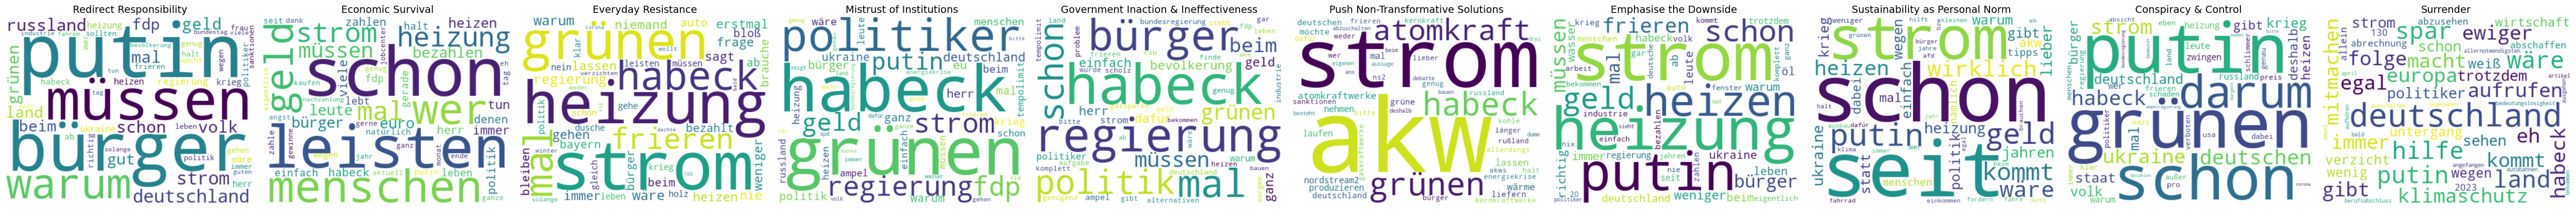

In [21]:
# Creation of a Word Cloud for each distinct discourse category 
categories = energy_df['discourse_category'].dropna().unique()
num_categories = len(categories)
fig, axes = plt.subplots(1, num_categories, figsize=(5*num_categories, 5), sharex=True, sharey=True)

for i, category in enumerate(categories):
    df_cat = energy_df[energy_df['discourse_category'] == category]
    additional_stopwords = ['energie', 'sparen', 'energiesparen', 'spare', 'ja', 'gas', 'mehr', 'sollen', 'geht']
    extended_stopwords = german_stopwords + additional_stopwords
    extended_stopwords = list(set(extended_stopwords)) 
    vectorizer = CountVectorizer(stop_words=extended_stopwords, max_features=500) 
    X = vectorizer.fit_transform(df_cat['content_short'])
    feature_names = vectorizer.get_feature_names_out()
    word_counts = np.asarray(X.sum(axis=0)).ravel()
    word_freq = {feature_names[j]: word_counts[j] for j in range(len(feature_names))}
    
    wc = WordCloud(width=400, height=300, background_color='white', colormap='viridis', contour_color='black', contour_width=1, max_words=50)  
    wc.generate_from_frequencies(word_freq)
    
    axes[i].imshow(wc, interpolation='bilinear')
    axes[i].set_title(f"{category_labels.get(str(category), category)}", fontsize=14)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

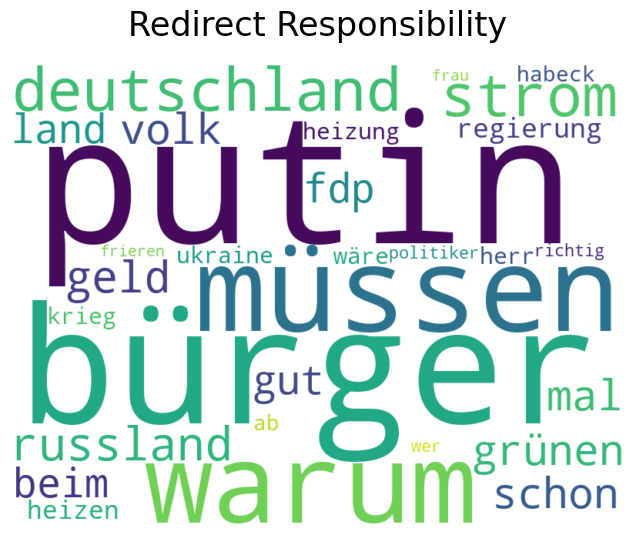

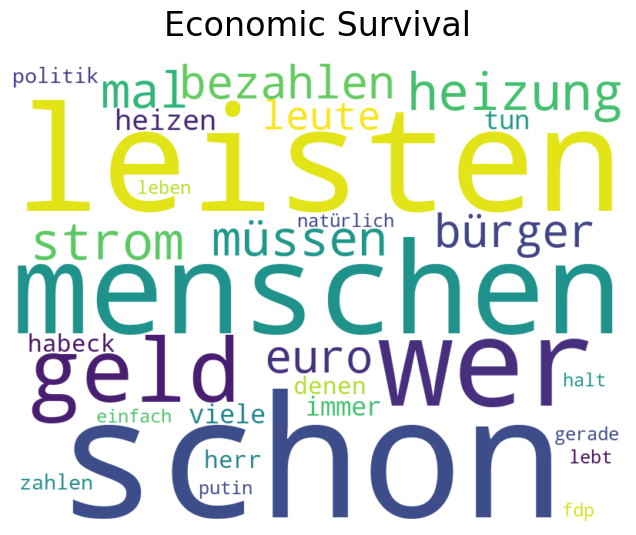

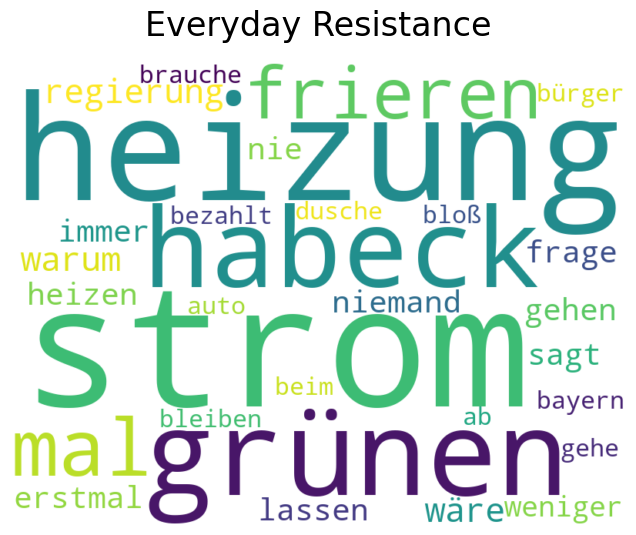

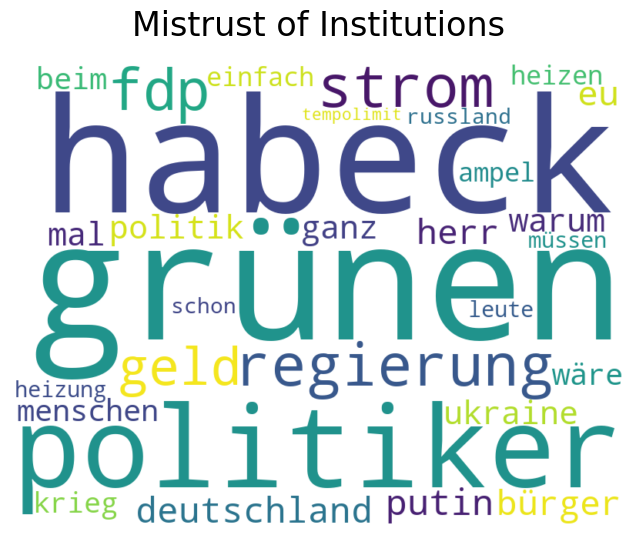

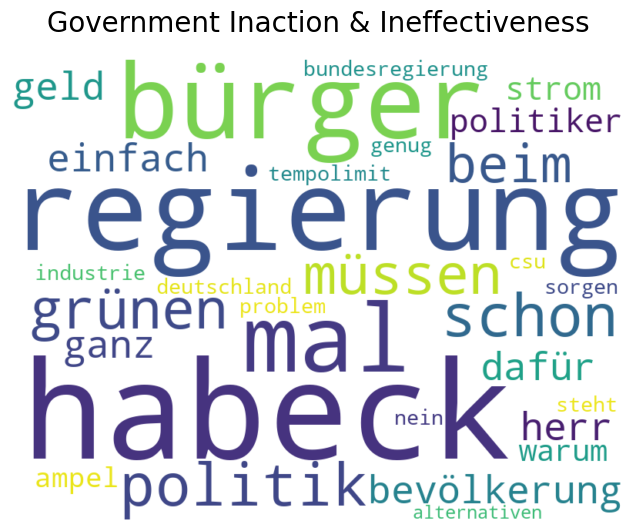

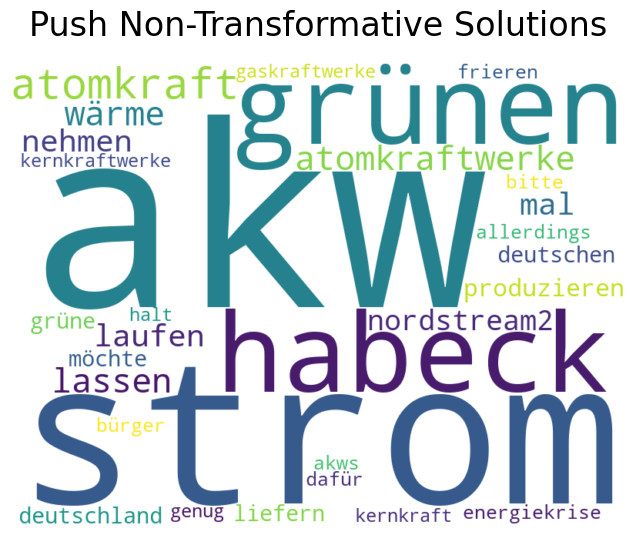

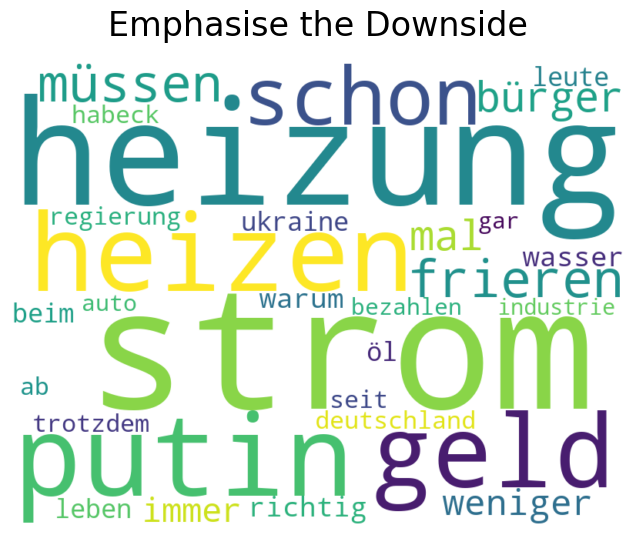

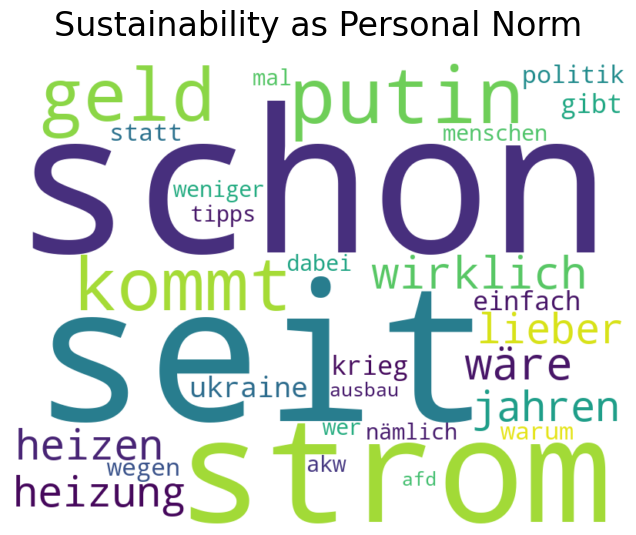

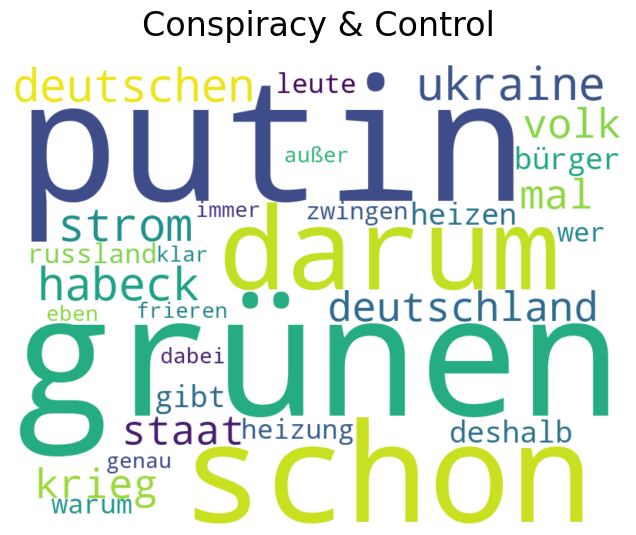

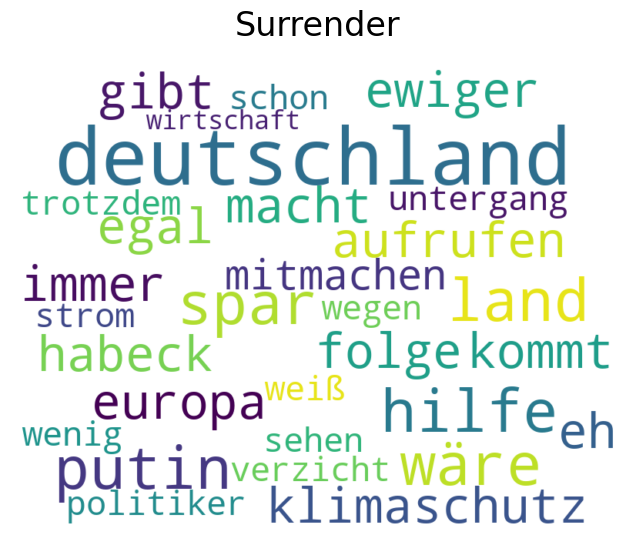

In [26]:
# Creation of a Word Cloud for each distinct discourse category (seperated)
categories = energy_df['discourse_category'].dropna().unique()

for category in categories:
    df_cat = energy_df[energy_df['discourse_category'] == category]
    additional_stopwords = ['energie', 'sparen', 'energiesparen', 'spare', 'ja', 'gas', 'mehr', 'sollen', 'geht']
    extended_stopwords = german_stopwords + additional_stopwords
    extended_stopwords = list(set(extended_stopwords))
    vectorizer = CountVectorizer(stop_words=extended_stopwords, max_features=1000)
    X = vectorizer.fit_transform(df_cat['content_short'])
    feature_names = vectorizer.get_feature_names_out()
    word_counts = np.asarray(X.sum(axis=0)).ravel()
    word_freq = {feature_names[j]: word_counts[j] for j in range(len(feature_names))}
    
    wc = WordCloud(width=800, height=600, background_color='white', colormap='viridis', 
                   contour_color='black', contour_width=1, max_words=30, prefer_horizontal=1.0)  
    wc.generate_from_frequencies(word_freq)
    
    plt.figure(figsize=(8, 6))
    plt.imshow(wc, interpolation='bilinear')
    if category == 10:
        plt.title(f"{category_labels.get(str(category), category)}", fontsize=20, pad=20)
    else:
        plt.title(f"{category_labels.get(str(category), category)}", fontsize=24, pad=20)
    plt.axis('off')
    plt.show()

In [23]:
# Analysis of Most influential tweets per discourse category

top_indices = energy_df.groupby('discourse_category')['total_engagement'].idxmax()
most_influential_tweets = energy_df.loc[top_indices]

columns_to_display = ['discourse_category', 'username', 'content_short', 'total_engagement', 'url']
most_influential_tweets_table = most_influential_tweets[columns_to_display]

for index, row in most_influential_tweets.iterrows():
    print(f"Discourse Category: {row['discourse_category']}")
    print(f"Username: {row['username']}")
    print(f"Tweet: {row['content_short']}")
    print(f"Total Engagement: {row['total_engagement']}")
    print("-" * 80)
    
output_file = "most_influential_tweets.csv"
most_influential_tweets_table.to_csv(output_file, index=False)

print(f"The table has been saved as {output_file}. You can download it.")


Discourse Category: 1
Username: nikitheblogger
Tweet: Der grüne Chef der Bundesnetzagentur schimpft, die Bürger würden noch nicht genug Gas sparen. Wozu soll auch irgendwer Gas sparen? Der Mangel ist von der Regierung verursacht. Hebt die Russland-Sanktionen auf und es ist genug Gas für alle da!
Total Engagement: 2619
--------------------------------------------------------------------------------
Discourse Category: 2
Username: HansMaiser999
Tweet: Ich wollte euch mitteilen das wir heute 7Uhr Gas in 13,146GW Strom gewandelt haben. #Habeck meint das der Strom von #AKWs nicht zum Gas sparen genutzt werden kann weil das nichts miteinander zu tun hat. Kein Journalist fragt nach. Meine Fresse! #Gasumlage #HabeckRuecktritt 
Total Engagement: 208
--------------------------------------------------------------------------------
Discourse Category: 3
Username: M_Reichardt_AfD
Tweet:  Jede Plenarwoche sieht man, wie  sich in völlig unkultivierter Weise vollstopft. Nie sehe ich dort Mäßigung oder